In [141]:
import pandas as pd
from stable_baselines3.common.logger import configure

from finrl.agents.stablebaselines3.models import DRLAgent as StockDRLAgent
from finrl.agents.portfolio_optimization.models import DRLAgent as OptDRLAgent

from finrl.config import TRAINED_MODEL_DIR, RESULTS_DIR
from finrl.main import check_and_make_directories
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv


TIME_WINDOW = 25
COMMISSION_FEE_PERCENT = 0.001
INITIAL_CASH = 1000000


TEST_START_DATE = '2021-01-01'
TEST_END_DATE = '2024-01-01'

# Backtest the results

train = pd.read_csv('train_data.csv')
test = pd.read_csv('test_data.csv')

# If you are not using the data generated from part 1 of this tutorial, make sure 
# it has the columns and index in the form that could be make into the environment. 
# Then you can comment and skip the following lines.
train = train.set_index(train.columns[0])
train.index.names = ['']
test = test.set_index(test.columns[0])
test.index.names = ['']


# Add additional technical indicators
INDICATORS = ['macd',
            'rsi_30',
            'cci_30',
            'dx_30']


FEATURES = ["close", "high", "low", "volume"].extend(INDICATORS)

In [142]:
test

,date,open,high,low,close,volume,tic,day,macd,rsi_30,cci_30,dx_30,turbulence
,,,,,,,,,,,,,
0,2021-01-04,133.520004,133.610001,126.760002,126.683426,143301900,AAPL,0,3.389452,56.613020,64.584069,8.436326,37.684697
0,2021-01-04,231.250000,231.250000,223.669998,201.544556,3088200,AMGN,0,-0.377975,48.078733,29.066787,1.082054,37.684697
0,2021-01-04,121.300003,121.800003,116.849998,112.164032,3472100,AXP,0,0.885393,54.746523,-8.190499,3.618340,37.684697
0,2021-01-04,210.000000,210.199997,202.490005,202.720001,21225600,BA,0,1.293101,50.209209,-132.990300,12.708438,37.684697
0,2021-01-04,183.000000,185.979996,180.250000,168.131165,4078300,CAT,0,1.918653,59.272580,142.190776,34.923782,37.684697
...,...,...,...,...,...,...,...,...,...,...,...,...,...
752,2023-12-29,525.979980,528.239990,523.919983,520.342346,2080100,UNH,4,-4.195767,49.266061,-73.945121,19.610609,2.911495
752,2023-12-29,260.570007,261.459991,259.670013,258.866302,4074600,V,4,2.695724,61.435349,108.048894,36.802092,2.911495
752,2023-12-29,37.380001,37.759998,37.320000,35.344772,16205200,VZ,4,0.237179,58.479745,5.362239,12.735613,2.911495


# Portfolio Optimization Algorithm

In [143]:
from finrl.meta.env_portfolio_optimization.env_portfolio_optimization import PortfolioOptimizationEnv


# Fit for the portfolio optimization model

from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.preprocessors import GroupByScaler

portfolio_norm_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(test)
portfolio_norm_df

df_test = portfolio_norm_df[(portfolio_norm_df["date"] >= TEST_START_DATE) & (portfolio_norm_df["date"] < TEST_END_DATE)]


environment = PortfolioOptimizationEnv(
    df_test,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    time_window=TIME_WINDOW,
    features=["close", "high", "low"],
    normalize_df=None
)

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\finrl\meta\preprocessor\preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.73325447 0.49973674 0.79356218 0.56069532 0.53807884 0.51365253
 0.47050007 0.4535413  0.4616515  0.57103289 0.46439158 0.53378733
 0.61479425 0.58567169 0.80647558 0.50345004 0.72067673 0.72977091
 0.90836283 0.54361322 0.42626132 0.45990717 0.43075238 0.38731389
 0.36481715 0.39284214 0.37376857 0.32891118 0.30775351 0.41229692
 0.50103437 0.4956013  0.44858818 0.53172473 0.80985935 0.56817462
 0.75831475 0.84203104 0.59513019 0.52325379 0.57803172 0.91159258
 0.78680078 0.78992206 0.66276421 0.57279718 0.52717125 0.45082067
 0.47281647 0.58960399 0.57274243 0.62031431 0.94942914 0.57263856
 0.48849092 0.45299737 0.5057736  0.48134831 0.4135398  0.43837034
 0.60544525 0.38421973 0.45361498 0.41022459 0.42708666 0.45460458
 0.54589994 0.46778252 0.466

In [144]:
import torch
from finrl.agents.portfolio_optimization.architectures import EIIE

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# set PolicyGradient parameters
model_kwargs = {
    "lr": 0.01,
    "policy": EIIE,
}

# here, we can set EIIE's parameters
policy_kwargs = {
    "k_size": 3,
    "time_window": TIME_WINDOW,
}


# instantiate an architecture with the same arguments used in training
# and load with load_state_dict.
policy = EIIE(time_window=TIME_WINDOW, device=device)
policy.load_state_dict(torch.load("policy_EIIE.pt"))

C:\Users\bencj\AppData\Local\Temp\ipykernel_33236\3962532677.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy.load_state_dict(torch.load("policy_EIIE.pt"))


<All keys matched successfully>

In [145]:
EIIE_results = {
    "20212024": {},
}

# 2021 - 2024
# Initialize the model
model = OptDRLAgent(environment).get_model("pg", device, model_kwargs, policy_kwargs)
OptDRLAgent.DRL_validation(model, environment, policy=policy)
EIIE_results["20212024"]["value"] = environment._asset_memory["final"]
EIIE_results["20212024"]["date"] = environment._date_memory



# Write this out to a csv file, with date and net worth
df_opt = pd.DataFrame(EIIE_results["20212024"]["value"], columns=['opt_net_worth'])
df_date = pd.DataFrame(EIIE_results["20212024"]["date"], columns=['Date'])
if len(df_opt) == len(df_date):
    df_opt['Date'] = df_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")


# The optimization algoirhtm has a shorter window than the full df, so shorted this for the follow algorithm
opt_start = df_opt.loc[0,'Date']


Initial portfolio value:1000000
Final portfolio value: 1254498.125
Final accumulative portfolio value: 1.254498125
Maximum DrawDown: -0.21709820619408282
Sharpe ratio: 0.5970868865593812
Total commission cost: 7205.580569965532


In [146]:
print(df_opt)

     opt_net_worth       Date
0     1.000000e+06 2021-02-08
1     9.990958e+05 2021-02-09
2     1.000379e+06 2021-02-10
3     1.000992e+06 2021-02-11
4     1.002442e+06 2021-02-12
..             ...        ...
724   1.243482e+06 2023-12-22
725   1.250904e+06 2023-12-26
726   1.253831e+06 2023-12-27
727   1.255602e+06 2023-12-28
728   1.254498e+06 2023-12-29

[729 rows x 2 columns]


In [147]:
opt_end = df_opt.loc[len(df_date)-1,'Date']

print(opt_start)
opt_start = opt_start.strftime('%Y-%m-%d %H:%M:%S')


print(opt_end)
opt_end = opt_end.strftime('%Y-%m-%d %H:%M:%S')

2021-02-08 00:00:00
2023-12-29 00:00:00


# PPO On portfolio Opt

In [148]:
from finrl.meta.env_portfolio_optimization.env_portfolio_opt_stable import PortfolioOptStableEnv


# Fit for the portfolio optimization model

from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.preprocessors import GroupByScaler

from finrl.meta.preprocessor.preprocessors import data_split

from datetime import datetime, timedelta
# Make sure dates line up, TODO fix this for real dates
# Make sure we only test on the same data as the portfolio optimization algorithm
# Convert to datetime
opt_start_date = datetime.strptime(opt_start, '%Y-%m-%d %H:%M:%S')

# Subtract one day
new_opt_start_date = opt_start_date - timedelta(days=1)

# Convert back to string
new_opt_start_str = new_opt_start_date.strftime('%Y-%m-%d %H:%M:%S')

test = data_split(test, new_opt_start_str,opt_end)


portfolio_norm_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(test)
portfolio_norm_df

df_test_ppo = portfolio_norm_df[(portfolio_norm_df["date"] >= TEST_START_DATE) & (portfolio_norm_df["date"] < TEST_END_DATE)]


environment_ppo = PortfolioOptStableEnv(
    df_test_ppo,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    # time_window=TIME_WINDOW,
    features=["close", "high", "low"],
    normalize_df=None
)

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\finrl\meta\preprocessor\preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.36481715 0.39284214 0.37376857 0.32891118 0.30775351 0.41229692
 0.50103437 0.4956013  0.44858818 0.53172473 0.80985935 0.56817462
 0.75831475 0.84203104 0.59513019 0.52325379 0.57803172 0.91159258
 0.78680078 0.78992206 0.66276421 0.57279718 0.52717125 0.45082067
 0.47281647 0.58960399 0.57274243 0.62031431 0.94942914 0.57263856
 0.48849092 0.45299737 0.5057736  0.48134831 0.4135398  0.43837034
 0.60544525 0.38421973 0.45361498 0.41022459 0.42708666 0.45460458
 0.54589994 0.46778252 0.46699708 0.44630607 0.4571758  0.43453526
 0.48233586 0.48514041 0.35228035 0.43271418 0.4024787  0.34234343
 0.33779301 0.55139237 0.7731613  0.56203235 0.38445511 0.70389807
 0.42982009 0.39977087 0.40409461 0.4506472  0.64545391 0.57396894
 0.5416765  0.4191622  0.379

In [149]:
from stable_baselines3 import PPO
from finrl.config import TRAINED_MODEL_DIR


# Load the trained models
trained_ppo_opt = PPO.load(TRAINED_MODEL_DIR + "/agent_opt_ppo_10_27") 

In [150]:
from finrl.agents.portfolio_optimization.models_stable import DRLStableAgent


PPO_results = {
    "20212024": {},
}

values, dates = DRLStableAgent.DRL_prediction(trained_ppo_opt, environment_ppo)
PPO_results["20212024"]["value"] = environment_ppo._terminal_asset_memory["final"]
PPO_results["20212024"]["date"] = environment_ppo._terminal_date_memory


# Write this out to a csv file, with date and net worth
df_ppo_opt = pd.DataFrame(PPO_results["20212024"]["value"], columns=['ppo_opt_net_worth'])
df_ppo_date = pd.DataFrame(PPO_results["20212024"]["date"], columns=['Date'])
if len(df_ppo_opt) == len(df_ppo_date):
    df_ppo_opt['Date'] = df_ppo_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_ppo_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_ppo_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_ppo_opt.loc[len(df_ppo_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 1304055.375
Final accumulative portfolio value: 1.304055375
Maximum DrawDown: -0.176698501282476
Sharpe ratio: 0.7239729384134631
Total commission cost: 6820.806502811145
hit end!
     ppo_opt_net_worth       Date
0         1.000000e+06 2021-02-08
1         9.996332e+05 2021-02-09
2         1.001849e+06 2021-02-10
3         1.001855e+06 2021-02-11
4         1.004148e+06 2021-02-12
..                 ...        ...
724       1.291612e+06 2023-12-22
725       1.298289e+06 2023-12-26
726       1.302563e+06 2023-12-27
727       1.305070e+06 2023-12-28
728       1.304055e+06 2023-12-29

[729 rows x 2 columns]


In [151]:
df_ppo_opt.loc[0, 'Date']

Timestamp('2021-02-08 00:00:00')

In [152]:
df_opt.loc[0,'Date']

Timestamp('2021-02-08 00:00:00')

# Stock environment optimization algorithm

In [153]:
from finrl.meta.preprocessor.preprocessors import data_split

# Make sure we only test on the same data as the portfolio optimization algorithm
# test = data_split(test, opt_start,opt_end)


In [154]:
print(test)

           date        open        high         low       close    volume  \
0    2021-02-08  136.029999  136.960007  134.919998  134.225693  71297200   
0    2021-02-08  237.990005  239.630005  235.850006  211.245651   2258200   
0    2021-02-08  126.870003  128.399994  126.750000  122.045166   3360900   
0    2021-02-08  209.550003  211.990005  208.300003  211.949997  11182100   
0    2021-02-08  195.000000  197.539993  194.669998  183.223312   2725700   
..          ...         ...         ...         ...         ...       ...   
728  2023-12-29  525.979980  528.239990  523.919983  520.342346   2080100   
728  2023-12-29  260.570007  261.459991  259.670013  258.866302   4074600   
728  2023-12-29   37.380001   37.759998   37.320000   35.344772  16205200   
728  2023-12-29   26.440001   26.629999   25.750000   24.868887  10853300   
728  2023-12-29   52.509998   52.693333   52.386665   52.042637  21948300   

      tic  day      macd     rsi_30      cci_30      dx_30  turbulence  
0 

In [155]:
from stable_baselines3 import PPO, TD3, A2C
from finrl.config import TRAINED_MODEL_DIR


# Load the trained models
trained_ppo = PPO.load(TRAINED_MODEL_DIR + "/agent_ppo") 

trained_td3 = TD3.load(TRAINED_MODEL_DIR + "/agent_td3") 

trained_a2c = A2C.load(TRAINED_MODEL_DIR + "/agent_a2c") 

In [156]:
# Test out of sample performance

stock_dimension = len(test.tic.unique())
state_space = 1 + 2 * stock_dimension + len(INDICATORS) * stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 175


In [157]:
buy_cost_list = sell_cost_list = [COMMISSION_FEE_PERCENT] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": INITIAL_CASH,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}

In [158]:
e_trade_gym_ppo = StockTradingEnv(df = test, turbulence_threshold = 70, **env_kwargs)

df_account_value_ppo, df_actions_ppo = StockDRLAgent.DRL_prediction(
    model=trained_ppo, 
    environment = e_trade_gym_ppo,
    deterministic=True)

hit end!


In [159]:
df_account_value_ppo.rename(columns={'date': 'Date', 'account_value' : "ppo_value"}, inplace=True)
df_account_value_ppo

,Date,ppo_value
0,2021-02-08,1.000000e+06
1,2021-02-09,9.998589e+05
2,2021-02-10,9.999309e+05
3,2021-02-11,1.000424e+06
4,2021-02-12,1.000145e+06
...,...,...
724,2023-12-22,8.929314e+05
725,2023-12-26,8.926235e+05
726,2023-12-27,8.926824e+05
727,2023-12-28,8.929957e+05


In [160]:
e_trade_gym_td3 = StockTradingEnv(df = test, turbulence_threshold = 70, **env_kwargs)

df_account_value_td3, df_actions_td3 = StockDRLAgent.DRL_prediction(
    model=trained_td3, 
    environment = e_trade_gym_td3)

hit end!


In [161]:
df_account_value_td3.rename(columns={'date': 'Date', 'account_value' : "td3_value"}, inplace=True)
df_account_value_td3

,Date,td3_value
0,2021-02-08,1.000000e+06
1,2021-02-09,9.988008e+05
2,2021-02-10,9.991995e+05
3,2021-02-11,1.001729e+06
4,2021-02-12,1.001912e+06
...,...,...
724,2023-12-22,1.062893e+06
725,2023-12-26,1.061830e+06
726,2023-12-27,1.062064e+06
727,2023-12-28,1.061905e+06


In [162]:

e_trade_gym_a2c = StockTradingEnv(df = test, turbulence_threshold = 70, **env_kwargs)

df_account_value_a2c, df_actions_a2c = StockDRLAgent.DRL_prediction(
    model=trained_a2c, 
    environment = e_trade_gym_a2c)

df_account_value_a2c.rename(columns={'date': 'Date', 'account_value' : "a2c_value"}, inplace=True)
df_account_value_a2c

hit end!


,Date,a2c_value
0,2021-02-08,1.000000e+06
1,2021-02-09,1.000397e+06
2,2021-02-10,1.000156e+06
3,2021-02-11,9.994207e+05
4,2021-02-12,1.001940e+06
...,...,...
724,2023-12-22,9.263189e+05
725,2023-12-26,9.254791e+05
726,2023-12-27,9.259775e+05
727,2023-12-28,9.273054e+05


In [163]:
# Pull the DJI results

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline


df_dji_ = get_baseline(
        ticker="^DJI",
        start = df_date.loc[0,'Date'],
        end = df_date.loc[len(df_date)-1,'Date'])

stats = backtest_stats(df_dji_, value_col_name = 'close')

df_dji = pd.DataFrame()
df_dji['date'] = df_date['Date']
df_dji['dji'] = df_dji_['close'] / df_dji_['close'][0] * env_kwargs["initial_amount"]
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
print("df_dji: ", df_dji)


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (728, 8)
Annual return          0.065607
Cumulative returns     0.201504
Annual volatility      0.150610
Sharpe ratio           0.497817
Calmar ratio           0.299019
Stability              0.000021
Max drawdown          -0.219408
Omega ratio            1.088158
Sortino ratio          0.709531
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.010171
Daily value at risk   -0.018678
dtype: float64
df_dji:            date           dji
0   2021-02-08  1.000000e+06
1   2021-02-09  9.996836e+05
2   2021-02-10  1.001658e+06
3   2021-02-11  1.001432e+06
4   2021-02-12  1.002314e+06
..         ...           ...
724 2023-12-22  1.191176e+06
725 2023-12-26  1.196254e+06
726 2023-12-27  1.199796e+06
727 2023-12-28  1.201504e+06
728 2023-12-29           NaN

[729 rows x 2 columns]
df_dji:                       dji
date                    
2021-02-08  1.000000e+06
2021-02-09  9.996836e+05
2021-02-10  1.001658e+06
2021-02-11  1.001432e+06

# Compare all results

In [164]:
# Join the online algorithms

bcrp = pd.read_csv('BCRP_net_worth.csv')
crp = pd.read_csv('CRP_net_worth.csv')
olmar = pd.read_csv('OLMAR_net_worth.csv')



merged_df = pd.merge(bcrp, crp, on='Date')
merged_df = pd.merge(merged_df, olmar, on='Date')


merged_df['Date'] = pd.to_datetime(merged_df['Date'])

# Merge the opt algorithm
df_opt['Date'] = pd.to_datetime(df_opt['Date'])
merged_df = pd.merge(merged_df, df_opt, on='Date')

# Merge the PPO opt algorithm
df_ppo_opt['Date'] = pd.to_datetime(df_ppo_opt['Date'])
merged_df = pd.merge(merged_df, df_ppo_opt, on='Date')


# Merge the PPO StockEnv data
df_account_value_ppo['Date'] = pd.to_datetime(df_account_value_ppo['Date'])
merged_df = pd.merge(merged_df, df_account_value_ppo, on='Date')


# Merge the TD3 StockEnv data
df_account_value_td3['Date'] = pd.to_datetime(df_account_value_td3['Date'])
merged_df = pd.merge(merged_df, df_account_value_td3, on='Date')


# Merge the A2C StockEnv data
df_account_value_a2c['Date'] = pd.to_datetime(df_account_value_a2c['Date'])
merged_df = pd.merge(merged_df, df_account_value_a2c, on='Date')



print(df_dji)
df_dji = df_dji.reset_index()
df_dji.rename(columns={'date': 'Date'}, inplace=True)
merged_df = pd.merge(merged_df, df_dji, on='Date')


print(merged_df)


                     dji
date                    
2021-02-08  1.000000e+06
2021-02-09  9.996836e+05
2021-02-10  1.001658e+06
2021-02-11  1.001432e+06
2021-02-12  1.002314e+06
...                  ...
2023-12-22  1.191176e+06
2023-12-26  1.196254e+06
2023-12-27  1.199796e+06
2023-12-28  1.201504e+06
2023-12-29           NaN

[729 rows x 1 columns]
          Date  BCRP_net_worth  CRP_net_worth  OLMAR_net_worth  opt_net_worth  \
0   2021-02-08    1.000000e+06   1.000000e+06     1.000000e+06   1.000000e+06   
1   2021-02-09    9.990033e+05   9.990031e+05     9.991499e+05   9.990958e+05   
2   2021-02-10    9.992571e+05   1.000282e+06     1.000435e+06   1.000379e+06   
3   2021-02-11    1.000928e+06   1.000890e+06     1.001009e+06   1.000992e+06   
4   2021-02-12    1.001753e+06   1.002336e+06     1.002472e+06   1.002442e+06   
..         ...             ...            ...              ...            ...   
724 2023-12-22    1.422336e+06   1.242695e+06     1.170318e+06   1.243482e+06   
725

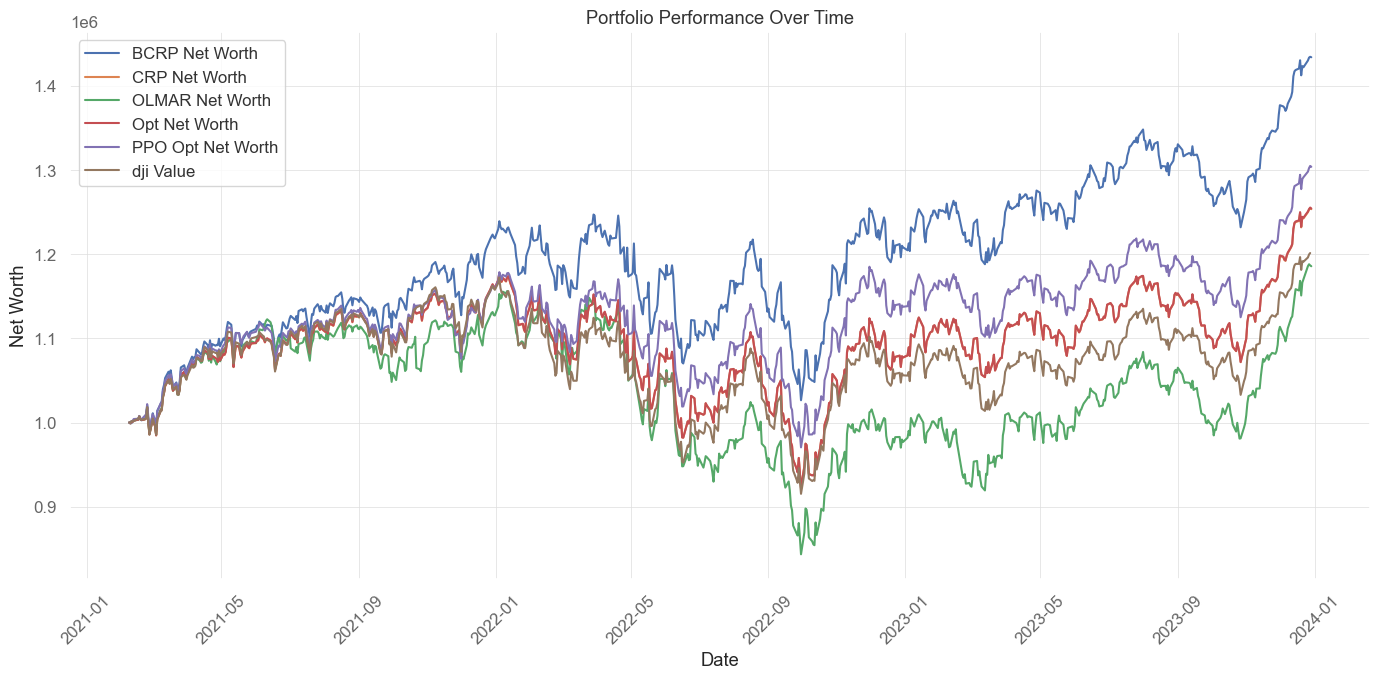

In [165]:
# Use the correct backend for Jupyter
%matplotlib inline
import matplotlib.pyplot as plt

# TODO make sure all dates line up, fix CRP and OLMAR 

# Plot the DataFrame
plt.figure(figsize=(14, 7))
plt.plot(merged_df['Date'], merged_df['BCRP_net_worth'], label='BCRP Net Worth')
plt.plot(merged_df['Date'], merged_df['CRP_net_worth'], label='CRP Net Worth')# CRP and Opt net worth are basically on the same line
plt.plot(merged_df['Date'], merged_df['OLMAR_net_worth'], label='OLMAR Net Worth')
plt.plot(merged_df['Date'], merged_df['opt_net_worth'], label='Opt Net Worth')
plt.plot(merged_df['Date'], merged_df['ppo_opt_net_worth'], label='PPO Opt Net Worth')
# plt.plot(merged_df['Date'], merged_df['ppo_value'], label='PPO Value')
# plt.plot(merged_df['Date'], merged_df['td3_value'], label='TD3 Value')
# plt.plot(merged_df['Date'], merged_df['a2c_value'], label='A2C Value')
plt.plot(merged_df['Date'], merged_df['dji'], label='dji Value')
plt.xlabel('Date')
plt.ylabel('Net Worth')
plt.title('Portfolio Performance Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [169]:
import numpy as np

# Calculate the returns each day

merged_df['BCRP_daily_return'] = merged_df['BCRP_net_worth'].pct_change()
merged_df['CRP_daily_return'] = merged_df['CRP_net_worth'].pct_change()
merged_df['OLMAR_daily_return'] = merged_df['OLMAR_net_worth'].pct_change()
merged_df['opt_daily_return'] = merged_df['opt_net_worth'].pct_change()
merged_df['ppo_opt_daily_return'] = merged_df['ppo_opt_net_worth'].pct_change()
merged_df['ppo_daily_return'] = merged_df['ppo_value'].pct_change()
merged_df['td3_daily_return'] = merged_df['td3_value'].pct_change()

# TODO need to put in the fama french

# Define the risk-free rate (annual, for example, 2%)
risk_free_rate = 0.02 / 252  # Convert annual risk-free rate to daily

# Define a function to calculate Sharpe ratio adjusted for the risk-free rate
def calculate_sharpe_ratio(returns, risk_free_rate):
    excess_return = returns - risk_free_rate
    mean_excess_return = excess_return.mean()
    std_excess_return = excess_return.std()
    annual_factor = np.sqrt(252)  # Assuming 252 trading days in a year
    sharpe_ratio = annual_factor * mean_excess_return / std_excess_return
    return sharpe_ratio

# Calculate the Sharpe ratio for each daily return column
sharpe_ratios = {
    'BCRP': calculate_sharpe_ratio(merged_df['BCRP_daily_return'], risk_free_rate),
    'CRP': calculate_sharpe_ratio(merged_df['CRP_daily_return'], risk_free_rate),
    'OLMAR': calculate_sharpe_ratio(merged_df['OLMAR_daily_return'], risk_free_rate),
    'Opt': calculate_sharpe_ratio(merged_df['opt_daily_return'], risk_free_rate),
    'PPO Opt': calculate_sharpe_ratio(merged_df['ppo_opt_daily_return'], risk_free_rate),
    'PPO': calculate_sharpe_ratio(merged_df['ppo_daily_return'], risk_free_rate),
    'TD3': calculate_sharpe_ratio(merged_df['td3_daily_return'], risk_free_rate)
}

print(sharpe_ratios)

{'BCRP': 0.7678098413566294, 'CRP': 0.4638575458625203, 'OLMAR': 0.3176747838017839, 'Opt': 0.46439084839933065, 'PPO Opt': 0.5820954449665633, 'PPO': -0.500483919974598, 'TD3': 0.07211832776157946}


In [170]:
import pandas as pd
import numpy as np

# Assuming merged_df is your DataFrame
# Calculate the max drawdown for each specified column
def max_drawdown(series):
    cumulative_returns = series.cummax()
    drawdowns = series / cumulative_returns - 1
    max_drawdown_value = drawdowns.min()
    return max_drawdown_value

max_drawdowns = {
    'BCRP': max_drawdown(merged_df['BCRP_net_worth']),
    'CRP': max_drawdown(merged_df['CRP_net_worth']),
    'OLMAR': max_drawdown(merged_df['OLMAR_net_worth']),
    'Opt': max_drawdown(merged_df['opt_net_worth']),
    'PPO Opt': max_drawdown(merged_df['ppo_opt_net_worth']),
    'PPO': max_drawdown(merged_df['ppo_value']),
    'TD3': max_drawdown(merged_df['td3_value'])
}

print(max_drawdowns)


{'BCRP': -0.1770203985809875, 'CRP': -0.21647755441070393, 'OLMAR': -0.2706940262106404, 'Opt': -0.21709820619408282, 'PPO Opt': -0.176698501282476, 'PPO': -0.2629247190757025, 'TD3': -0.21325862993142608}


In [171]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols


# TODO can we do a statisitical significance test with anova here?
ANOVA_cols = ['CRP_daily_return', 'td3_value', 'opt_net_worth', 'ppo_daily_return', 'ppo_opt_net_worth']
cols = ['Date',] + ANOVA_cols


df_selected = merged_df[cols]

# Assuming merged_df is your DataFrame and daily returns have already been calculated
# Combine all return columns into one DataFrame for ANOVA
returns_long = df_selected.melt(
    id_vars=['Date'], 
    value_vars=ANOVA_cols,
    var_name='Portfolio', 
    value_name='Daily_Return'
)

# Remove any NaN values created by pct_change()
returns_long.dropna(inplace=True)

# Perform ANOVA
model = ols('Daily_Return ~ Portfolio', data=returns_long).fit()
anova_result = sm.stats.anova_lm(model, typ=2)

# Display the summary of the ANOVA
print(anova_result)

# The results do seem to be statisitcally significant


                 sum_sq      df              F  PR(>F)
Portfolio  1.044667e+15     4.0  121425.875858     0.0
Residual   7.824731e+12  3638.0            NaN     NaN
